# Object detection for animal welfare: giraffes, zebras and elephants

*This exercise is based on the respective problem sets in the Deep Learning Specialization from deeplearning.ai (https://www.coursera.org/specializations/deep-learning). And the YOLOv4 Notebook by dsbyprateekg (https://github.com/dsbyprateekg/YOLOv4/blob/master/yolov4_to_tf2.ipynb).*

Welcome ths programming assignment. This assignment is split into two parts. First, we will recap YOLOv1 and you will implement some of the needed functions yourself. The ideas mainly come from the two YOLO papers: [Redmon et al., 2016](https://arxiv.org/abs/1506.02640) and [Redmon and Farhadi, 2016](https://arxiv.org/abs/1612.08242). In the second part, we will use a more recent version of YOLO: YOLOv4. We will be loading the pre-trained weights and apply it to car-front-camera images. 

**You will learn to**:
- Use object detection on a wildlife dataset
- Deal with bounding boxes
- Use pre-trained weights for YOLOv4 and apply the model to our test data

## Import libraries


In [1]:
import numpy as np
import tensorflow as tf


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## 1 - Project Overview

You are engaged in a wildlife conservation project. A key element of this initiative is to develop an animal detection system. To gather data, you've equipped a camera on a drone or a vehicle, which captures images of the wildlife environment at regular intervals while you move through different habitats.

You've gathered all these images into a folder and have labelled them by drawing bounding boxes around every animal you found. Here's an example of what your bounding boxes look like.

<img src="nb_images/box_label1.png" style="width:500px;height:250;">
<caption><center> <u> **Figure 1** </u>: **Definition of a box**<br> </center></caption>


If you are training an object detector to recognize 80 classes, you can represent the class label $c$ in two ways: as an integer from 1 to 80, or as an 80-dimensional one-hot encoded vector with one element set to 1 and the rest to 0. In this notebook, both representations will be used, depending on which is more convenient for each specific step.

The aim of this notebook is to develop a robust object detection system using TensorFlow, capable of automatically identifying and counting giraffes, zebras, and elephants in images. This system will assist conservation organizations in more efficiently monitoring and managing the populations of these animals. Automating this process can save valuable resources and enhance the protection of these fascinating species.

## 2 - YOLO

"You Only Look Once" (YOLO) is a well-regarded algorithm known for its high accuracy and ability to work in real-time. The term "only looks once" means that the algorithm needs just a single pass through its network to predict what's in an image. It quickly analyzes the image, identifies objects, and places boxes around them. This process, called non-max suppression, ensures YOLO outputs the most accurate object locations.

### 2.1 - Model details

#### Inputs and outputs
- The **input** involves a collection of images, each of which is resized to the dimensions (m, 608, 608, 3) before processing.
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this assignment, 5 anchor boxes were chosen for you (to cover the 80 classes).
* The dimension for anchor boxes is the second to last dimension in the encoding: $(m, n_H, n_W, anchors, classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).  


#### Encoding
Let's look in greater detail at what this encoding represents. 

<img src="nb_images/architecture1.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 2** </u>: **Encoding architecture for YOLO**<br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

<img src="nb_images/flatten.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 3** </u>: **Flattening the last two last dimensions**<br> </center></caption>

#### Class score

Now, for each box (of each cell) we will compute the following element-wise product and extract a probability that the box contains a certain class.  
The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

<img src="nb_images/probability_extraction1.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 4** </u>: **Find the class detected by each box**<br> </center></caption>

##### Example of figure 4
* In figure 4, let's say for box 1 (cell 1), the probability that an object exists is $p_{1}=0.60$.  So there's a 60% chance that an object exists in box 1 (cell 1).  
* The probability that the object is the class "category 3 (a giraffe)" is $c_{3}=0.73$.  
* The score for box 1 and for category "3" is $score_{1,3}=0.60 \times 0.73 = 0.44$.  
* Let's say we calculate the score for all 80 classes in box 1, and find that the score for the car class (class 3) is the maximum.  So we'll assign the score 0.44 and class "3" to this box "1".

#### Visualizing classes
Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across the 80 classes, one maximum for each of the 5 anchor boxes).
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="nb_images/proba_map.png" style="width:300px;height:300;">
<caption><center> <u> **Figure 5** </u>: Each one of the 19x19 grid cells is colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 


#### Visualizing bounding boxes
Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="nb_images/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u> **Figure 6** </u>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

#### Non-Max suppression
In the figure above, we plotted only boxes for which the model had assigned a high probability, but this is still too many boxes. You'd like to reduce the algorithm's output to a much smaller number of detected objects.  

To do so, you'll use **non-max suppression**. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class; either due to the low probability of any object, or low probability of this particular class).
- Select only one box when several boxes overlap with each other and detect the same object.



### 2.2 - Filtering with a threshold on class scores

You are going to first apply a filter by thresholding. You would like to get rid of any box for which the class "score" is less than a chosen threshold. 

The model gives you a total of 19x19x5x85 numbers, with each box described by 85 numbers. It is convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19 \times 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19 \times 19, 5, 4)$ containing the midpoint and dimensions $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes in each cell.
- `box_class_probs`: tensor of shape $(19 \times 19, 5, 80)$ containing the "class probabilities" $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.

#### **Exercise**: Implement `yolo_filter_boxes()`.
1. Compute box scores by doing the elementwise product as described in Figure 4 ($p \times c$).  
The following code may help you choose the right operator: 
```python
a = np.random.randn(19*19, 5, 1)
b = np.random.randn(19*19, 5, 80)
c = a * b # shape of c will be (19*19, 5, 80)
```
This is an example of **broadcasting** (multiplying vectors of different sizes).

2. For each box, find:
    - the index of the class with the maximum box score
    - the corresponding box score
    
    **Additional Hints**
    
        * For the `axis` parameter of `argmax` and `max`, if you want to select the **last** axis, one way to do so is to set `axis=-1`.  This is similar to Python array indexing, where you can select the last position of an array using `arrayname[-1]`.

        * Applying `max` normally collapses the axis for which the maximum is applied.  `keepdims=False` is the default option, and allows that dimension to be removed.  We don't need to keep the last dimension after applying the maximum here.
        
        * Even though the documentation shows `keras.backend.argmax`, use `keras.argmax`.  Similarly, use `keras.max`.


3. Create a mask by using a threshold. As a reminder: `([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4)` returns: `[False, True, False, False, True]`. The mask should be True for the boxes you want to keep. 

4. Use TensorFlow to apply the mask to `box_class_scores`, `boxes` and `box_classes` to filter out the boxes we don't want. You should be left with just the subset of boxes you want to keep.   

    **Useful reference**:
    * [boolean mask](https://www.tensorflow.org/api_docs/python/tf/boolean_mask)  

   **Additional Hints**:  
    * For the `tf.boolean_mask`, we can keep the default `axis=None`.

**Reminder**: to call a tensorflow function, you should use `tf.function(...)`. For example for tf.argmax() or tf.reduce_max().

In [2]:
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    ### START CODE HERE ### (≈ 1 line)
    box_scores = box_confidence * box_class_probs
    ### END CODE HERE ###
    
    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    ### START CODE HERE ### (≈ 2 lines)
    box_classes = tf.argmax(box_scores, axis = -1)
    box_class_scores = tf.reduce_max(box_scores, axis = -1, keepdims=False)
    ### END CODE HERE ###
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ### START CODE HERE ### (≈ 1 line)
    filtering_mask = (box_class_scores >= threshold)
    ### END CODE HERE ###
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [3]:
tf.random.set_seed(1)
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

scores[2] = 155.9314
boxes[2] = [ 2.2713618  6.829959  -4.093821   0.9525691]
classes[2] = 70
scores.shape = (1781,)
boxes.shape = (1781, 4)
classes.shape = (1781,)


**Expected Output**:

scores[2] = 155.9314

boxes[2] = [ 2.2713618  6.829959  -4.093821   0.9525691]

classes[2] = 70

scores.shape = (1781,)

boxes.shape = (1781, 4)

classes.shape = (1781,)


**Note** In the test for `yolo_filter_boxes`, we're using random numbers to test the function.  In real data, the `box_class_probs` would contain non-zero values between 0 and 1 for the probabilities.  The box coordinates in `boxes` would also be chosen so that lengths and heights are non-negative.

### 2.3 - Non-max suppression ###

Even after filtering by thresholding over the class scores, you still end up with a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

<img src="nb_images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> **Figure 7** </u>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probability) of the 3 boxes. <br> </center></caption>


Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="nb_images/iou.png" style="width:500px;height:400;">
<caption><center> <u> **Figure 8** </u>: Definition of "Intersection over Union". <br> </center></caption>

#### **Exercise**: Implement iou(). Some hints:
- In this code, we use the convention that (0,0) is the top-left corner of an image, (1,0) is the upper-right corner, and (1,1) is the lower-right corner. In other words, the (0,0) origin starts at the top left corner of the image. As x increases, we move to the right.  As y increases, we move down.
- For this exercise, we define a box using its two corners: upper left $(x_1, y_1)$ and lower right $(x_2,y_2)$, instead of using the midpoint, height and width. (This makes it a bit easier to calculate the intersection).
- To calculate the area of a rectangle, multiply its height $(y_2 - y_1)$ by its width $(x_2 - x_1)$. (Since $(x_1,y_1)$ is the top left and $x_2,y_2$ are the bottom right, these differences should be non-negative.
- To find the **intersection** of the two boxes $(xi_{1}, yi_{1}, xi_{2}, yi_{2})$: 
    - Feel free to draw some examples on paper to clarify this conceptually.
    - The top left corner of the intersection $(xi_{1}, yi_{1})$ is found by comparing the top left corners $(x_1, y_1)$ of the two boxes and finding a vertex that has an x-coordinate that is closer to the right, and y-coordinate that is closer to the bottom.
    - The bottom right corner of the intersection $(xi_{2}, yi_{2})$ is found by comparing the bottom right corners $(x_2,y_2)$ of the two boxes and finding a vertex whose x-coordinate is closer to the left, and the y-coordinate that is closer to the top.
    - The two boxes **may have no intersection**.  You can detect this if the intersection coordinates you calculate end up being the top right and/or bottom left corners of an intersection box.  Another way to think of this is if you calculate the height $(y_2 - y_1)$ or width $(x_2 - x_1)$ and find that at least one of these lengths is negative, then there is no intersection (intersection area is zero).  
    - The two boxes may intersect at the **edges or vertices**, in which case the intersection area is still zero.  This happens when either the height or width (or both) of the calculated intersection is zero.


**Additional Hints**

- `xi1` = **max**imum of the x1 coordinates of the two boxes
- `yi1` = **max**imum of the y1 coordinates of the two boxes
- `xi2` = **min**imum of the x2 coordinates of the two boxes
- `yi2` = **min**imum of the y2 coordinates of the two boxes
- `inter_area` = You can use `max(height, 0)` and `max(width, 0)`


In [4]:
# GRADED FUNCTION: iou

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2

    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    # Assign variable names to coordinates for clarity
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ### START CODE HERE ### (≈ 7 lines)
    xi1 = np.maximum(box1[0], box2[0])
    yi1 = np.maximum(box1[1], box2[1])
    xi2 = np.minimum(box1[2], box2[2])
    yi2 = np.minimum(box1[3], box2[3])
    inter_width = xi2 - xi1
    inter_height = yi2 - yi1
    # Case in which they don't intersec --> max(,0)
    inter_area = max(inter_width, 0) * max(inter_height, 0)
    ### END CODE HERE ###    

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ### START CODE HERE ### (≈ 3 lines)
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    union_area = box1_area + box2_area - inter_area
    ### END CODE HERE ###
    
    # compute the IoU
    ### START CODE HERE ### (≈ 1 line)
    iou = float(inter_area)/float(union_area)
    ### END CODE HERE ###
    
    return iou

In [5]:
## Test case 1: boxes intersect
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou for intersecting boxes = " + str(iou(box1, box2)))

## Test case 2: boxes do not intersect
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))

## Test case 3: boxes intersect at vertices only
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))

## Test case 4: boxes intersect at edge only
box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2)))

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0


**Expected Output**:

```
iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0
```

#### YOLO non-max suppression

You are now ready to implement non-max suppression. The key steps are: 
1. Select the box that has the highest score.
2. Compute the overlap of this box with all other boxes, and remove boxes that overlap significantly (iou >= `iou_threshold`).
3. Go back to step 1 and iterate until there are no more boxes with a lower score than the currently selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.

**Exercise**: Implement yolo_non_max_suppression() using TensorFlow. TensorFlow has two built-in functions that are used to implement non-max suppression (so you don't actually need to use your `iou()` implementation):

** Reference documentation ** 

- [tf.image.non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)
```
tf.image.non_max_suppression(
    boxes,
    scores,
    max_output_size,
    iou_threshold=0.5,
    name=None
)
```
Note that in the version of tensorflow used here, there is no parameter `score_threshold` (it's shown in the documentation for the latest version) so trying to set this value will result in an error message: *got an unexpected keyword argument 'score_threshold.*

- [tf.gather()](https://www.tensorflow.org/api_docs/python/tf/gather)
```
tf.gather(
    reference,
    indices
)
```

In [6]:
# GRADED FUNCTION: yolo_non_max_suppression

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
   
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ### START CODE HERE ### (≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=max_boxes, iou_threshold=iou_threshold)
    ### END CODE HERE ###
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [7]:
tf.random.set_seed(1)
scores = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed = 1)
classes = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

scores[2] = 7.2217274
boxes[2] = [-0.4885149  -0.7482592   1.5157948   0.82847375]
classes[2] = -3.8691611
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


**Expected Output**:

scores[2] = 7.2217274

boxes[2] = [-0.4885149  -0.7482592   1.5157948   0.82847375]

classes[2] = -3.8691611

scores.shape = (10,)

boxes.shape = (10, 4)

classes.shape = (10,)

## <font color='red'>What you should remember:
- YOLO is an object detection model that is fast and accurate
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- You select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output.
- Because training a YOLO model from randomly initialized weights is non-trivial and requires a large dataset as well as lot of computation, we used previously trained model parameters in this exercise. If you wish, you can also try fine-tuning the YOLO model with your own dataset, though this would be a fairly non-trivial exercise. 

## 3 - Test YOLOv4 pre-trained model on images

In this part, you are going to use a pre-trained YOLOv4 model and test it on the car detection dataset. Note that we are switching the YOLO version to v4.

### 3.1 - Loading and running the pre-trained YOLO model

* Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. 
* You are going to load an existing pre-trained Keras YOLO model stored in "model/yolov4.weights". 
* These weights come from the official YOLO website. These are the parameters from the "YOLOv4" model.


In [8]:
from keras.layers import Input, UpSampling2D, MaxPool2D, concatenate
from keras.models import Model
from keras.utils import get_custom_objects
from yolo4.yolo_utils import _conv_block, Mish, mish

In [9]:
# add the YOLOv4 newly added activation function MISH
get_custom_objects().update({'mish': Mish(mish)})

# define YOLOv4 architecture


def make_yolov4_model():

    input_image = Input(shape=(608, 608, 3), name='input_0')

    # Layer  0
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 0}])
    layer_0 = x
    # Layer  1
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 1}])
    layer_1 = x

    # Layer  2
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 2}])
    layer_2 = x

    # route  1 (layers = -2)
    x = layer_1
    # Layer  3 => 5
    x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 4},
                        {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 5},
                        {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 6}],
                    skip=True)

    # Layer  8 => 8
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 8}])
    layer_8 = x

    # route  8+2 (layers = -1, -7)
    x = concatenate([layer_8, layer_2], name='concat_9')

    # Layer 10 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 10},
                        {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 11}])
    layer_11 = x

    # Layer  12
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 12}])
    layer_12 = x

    # route  11 (layers = -2)
    x = layer_11
    # Layer 14 => 16
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 14},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 15},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 16}],
                    skip=True)

    # Layer 18 => 19
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 18},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 19}],
                    skip=True)

    # Layer  21
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 21}])
    layer_21 = x

    # route  21+12 (layers = -1,-10)
    x = concatenate([layer_21, layer_12], name='concat_22')

    # Layer 23 => 24
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 23},
                        {'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 24}])
    layer_24 = x

    # Layer  25
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 25}])
    layer_25 = x

    # route  24 (layers = -2)
    x = layer_24

    # Layer 27 => 29
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 27},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 28},
                        {'filter':  128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 29}],
                    skip=True)

    # Layer 31 => 50
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 31+(i*3)},
                            {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 32+(i*3)}],
                        skip=True)

    # Layer  52
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 52}])
    layer_52 = x

    # route  52+25 (layers = -1,-28)
    x = concatenate([layer_52, layer_25],  name='concat_53')

    # Layer 54
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 54}])
    layer_54 = x

    # Layer  55
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 55}])
    layer_55 = x

    # Layer  56
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 56}])
    layer_56 = x

    # route  55 (layers = -2)
    x = layer_55

    # Layer 58 => 60
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 58},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 59},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 60}],
                    skip=True)

    # Layer 62 => 81
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 62+(i*3)},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 63+(i*3)}],
                        skip=True)

    # Layer  83
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 83}])
    layer_83 = x

    # route  83+56 (layers = -1,-28)
    x = concatenate([layer_83, layer_56], name='concat_84')

    # Layer 85
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 85}])
    layer_85 = x

    # Layer  86
    x = _conv_block(x, [{'filter':  1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 86}])
    layer_86 = x

    # Layer  87
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 87}])
    layer_87 = x

    # route  86 (layers = -2)
    x = layer_86

    # Layer 89 => 92
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 89},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 90},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 91}],
                    skip=True)

    # Layer 93 => 100
    for i in range(3):
        x = _conv_block(x, [{'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 93+(i*3)},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 94+(i*3)}],
                        skip=True)

    # Layer  102 => 102
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 102}])
    layer_102 = x

    # route  102+87 (layers = -1,-16)
    x = concatenate([layer_102, layer_87], name='concat_103')

    # Layer 104 => 107
    x = _conv_block(x, [{'filter':  1024, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 104},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 105},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 106},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 107}])

    #-- begin SPP part (Spatial Pyramid Pooling layer)
    layer_107 = x

    # Layer 108
    x = MaxPool2D(pool_size=(5, 5), strides=1, padding='same', name='layer_108')(x)
    layer_108 = x

    # route  107 (layers = -2)
    x = layer_107

    # Layer 110
    x = MaxPool2D(pool_size=(9, 9), strides=1, padding='same', name='layer_110')(x)
    layer_110 = x

    # route  107 (layers = -4)
    x = layer_107

    # Layer 112
    x = MaxPool2D(pool_size=(13, 13), strides=1, padding='same', name='layer_112')(x)
    layer_112 = x

    # route  112+110+108+107 (layers=-1,-3,-5,-6)
    x = concatenate([layer_112, layer_110, layer_108, layer_107], name='concat_113')
    #-- end SPP part

    layer_113 = x

    # Layer 114 => 116
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 114},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 115},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 116}])
    layer_116 = x

    # Layer 117
    x = _conv_block(x, [{'filter':   256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 117}])
    layer_117 = x
    # Layer 118
    x = UpSampling2D(size=(2, 2), name='upsamp_118')(x)
    layer_118 = x

    # route  85 (layers = 85)
    x = layer_85

    # Layer 120
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 120}])
    layer_120 = x

    # route  120+118 (layers = -1, -3)
    x = concatenate([layer_120, layer_118],  name='concat_121')
    layer_121 = x
    # Layer 122 => 126
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 122},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 123},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 124},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 125},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 126}])
    layer_126 = x

    # Layer 127
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 127}])
    layer_127 = x
    # Layer 128
    x = UpSampling2D(size=(2, 2), name='upsamp_128')(x)
    layer_128 = x

    # route  54 (layers = 54)
    x = layer_54

    # Layer 130
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 130}])
    layer_130 = x

    # route  130+128 (layers = -1, -3)
    x = concatenate([layer_130, layer_128],  name='concat_131')
    layer_131 = x
    # Layer 132 => 136
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 132},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 133},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 134},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 135},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 136}])
    layer_136 = x

    # Layer 137 => 138
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 137}])
    layer_137 = x
    x = _conv_block(x, [{'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 138}])

    # Layer 139
    yolo_139 = x

    # route  136 (layers = -4)
    x = layer_136

    # Layer 141
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 141}])
    layer_141 = x

    # route  141+126 (layers = -1, -16)
    x = concatenate([layer_141, layer_126],  name='concat_142')

    # Layer 143 => 147
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 143},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 144},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 145},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 146},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 147}])
    layer_147 = x

    # Layer 148 => 149
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 148},
                        {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 149}])

    # Layer 150
    yolo_150 = x

    # route  147 (layers = -4)
    x = layer_147

    # Layer 152
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 152}])
    layer_152 = x

    # route  152+166 (layers = -1, -37)
    x = concatenate([layer_152, layer_116],  name='concat_153')

    # Layer 154 => 160
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 154},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 155},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 156},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 157},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 158},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 159},
                        {'filter':   255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    0, 'layer_idx': 160}])

    # Layer 161
    yolo_161 = x

    model = Model(input_image, [yolo_139, yolo_150, yolo_161], name='Yolo_v4')
    return model


In [10]:
# Define the model
model = make_yolov4_model()

# check model summary
model.summary()

# You can also plot the summary in TF
# tf.keras.utils.plot_model(model, show_shapes=True)


Model: "Yolo_v4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_0 (InputLayer)        [(None, 608, 608, 3)]        0         []                            
                                                                                                  
 convn_0 (Conv2D)            (None, 608, 608, 32)         896       ['input_0[0][0]']             
                                                                                                  
 zerop_1 (ZeroPadding2D)     (None, 609, 609, 32)         0         ['convn_0[0][0]']             
                                                                                                  
 convn_1 (Conv2D)            (None, 304, 304, 64)         18496     ['zerop_1[0][0]']             
                                                                                           

In [11]:
from yolo4.yolo_utils import WeightReader

# Load and Compute the YOLOv4 weights (these are not tensorflow weights, so they have to be converted by the WeightReader)
weight_reader = WeightReader('model/yolov4.weights')
weight_reader.load_weights(model)

reading 64 bytes


loading weights of convolution #0- nb parameters: 896
loading weights of convolution #1- nb parameters: 18496
loading weights of convolution #2- nb parameters: 4160
no convolution #3
loading weights of convolution #4- nb parameters: 4160
loading weights of convolution #5- nb parameters: 2080
loading weights of convolution #6- nb parameters: 18496
no convolution #7
loading weights of convolution #8- nb parameters: 4160
no convolution #9
loading weights of convolution #10- nb parameters: 8256
loading weights of convolution #11- nb parameters: 73856
loading weights of convolution #12- nb parameters: 8256
no convolution #13
loading weights of convolution #14- nb parameters: 8256
loading weights of convolution #15- nb parameters: 4160
loading weights of convolution #16- nb parameters: 36928
no convolution #17
loading weights of convolution #18- nb parameters: 4160
loading weights of convolution #19- nb parameters: 36928
no convolution #20
loading weights of convolution #21- nb parameters: 4

In [12]:
# Save the model in TF format
model.save('model/yolov4.h5')

c:\Users\Denni\VSCode\ML_JupyterNB\.conda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Verify the saved model using keras
# Load the model
from keras.models import load_model
yolo_model = load_model("model/yolov4.h5")

In [14]:
from yolo4.yolo_utils import read_labels

labels = read_labels('model/coco_classes.txt')
print("There are a total of {} classes in the coco label set.".format(len(labels)))

There are a total of 80 classes in the coco label set.


In [29]:
from yolo4.yolo_utils import load_image_pixels

# Pre-process the image: resize it to 
input_w, input_h = 608, 608
# Choose a file to run YOLO on
photo_filename = 'images/mixed3.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image", image.shape)

image initial size:  639 369
input image (1, 608, 608, 3)


In [30]:
# Run the model
yhat = yolo_model.predict(image)
print("output:", [a.shape for a in yhat])

1/1 [==============================] - 1s 905ms/step
output: [(1, 76, 76, 255), (1, 38, 38, 255), (1, 19, 19, 255)]


Note that the shapes of the output of YOLOv4 are highly different from YOLOv1. This is mainly due to that fact that YOLOv4 has three model heads that are specialized for detecting small, medium and large objects respectively. 

We will not go into details of the YOLOv4 implementation here, but rather put it straight to use. 

In [31]:
from yolo4.yolo_utils import decode_output_boxes

obj_thresh = 0.25
boxes = decode_output_boxes(yhat, obj_thresh, input_w, input_h) 

print("nb boxes detected: ", len(boxes))

grid_h,grid_w:  76 76
nb class:  80
grid_h,grid_w:  38 38
nb class:  80
grid_h,grid_w:  19 19
nb class:  80
objectness:  0.96800196
objectness:  0.9686422
objectness:  0.3778787
objectness:  0.40971848
objectness:  0.9949366
objectness:  0.99491227
nb boxes detected:  6


In [32]:
# Correct the boxes according the initial size of the image
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
 new_w, new_h = net_w, net_h
 for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [33]:
from yolo4.yolo_utils import do_nms

# non max suppression with yolov4 output
do_nms(boxes, 0.5)
print("nb boxes remaining; ", len(boxes))

nb boxes remaining;  6


In [34]:
from yolo4.yolo_utils import get_boxes

class_threshold = 0.25
v_boxes, v_labels, v_scores, v_colors = get_boxes(boxes, labels, class_threshold)
print("nb boxes remaining; ", len(v_boxes))

nb boxes remaining;  1


zebra 99.48280453681946 138 435 167 369


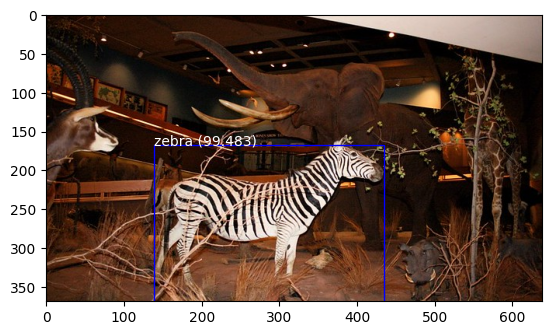

In [35]:
from yolo4.yolo_utils import draw_boxes

for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i],  v_boxes[i].xmin, v_boxes[i].xmax, v_boxes[i].ymin, v_boxes[i].ymax)

# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores, v_colors)

**Perfect, it's working as original YOLOv4 weights!**

### 3.2 - Applying Yolo to all test images

TODO: Your job now is to use the functions presented here to create a python script that runs yolov4 on all images in the folder "images" and save the results to a folder "images_detections". You should not use a jupyter notebook for this.

**References**: The ideas presented in this notebook came primarily from the two YOLO papers.
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 
- YOLOv4 Notebook by dsbyprateekg (https://github.com/dsbyprateekg/YOLOv4/blob/master/yolov4_to_tf2.ipynb) (2020)

**Wildlife detection dataset**: <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Sample data from </span><a rel="coco" href="[cocodataset.org](https://cocodataset.org/#termsofuse)">cocodataset.org</a> (provided by coco) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.